# Day 08. Exercise 00
# Binary classifier. Logistic regression

## 0. Imports

In [66]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

## 1. Preprocessing

- Get the data from the file [`checker-timestamp.csv`](https://drive.google.com/file/d/1pooM4cITtG249msX3GK_6W0eEiblzAf5/view?usp=sharing).


- Create a dataframe `df` with the columns: `date`, `am`, `pm`, `target`, where `date` is the date of the day, `am` is the number of the commits during the day before midday (integer), `pm` is the number of commits during the day after midday (integer), `target` is weekend/working_day.

In [67]:
df = pd.read_csv('../data/checker_timestamp.csv', parse_dates=['timestamp'])
df

,timestamp
0,2020-04-17 05:19:02.744528
1,2020-04-17 05:22:35.249331
2,2020-04-17 05:22:45.549397
3,2020-04-17 05:34:14.691200
4,2020-04-17 05:34:24.422370
...,...
3202,2020-05-21 20:19:06.872761
3203,2020-05-21 20:22:41.785725
3204,2020-05-21 20:22:41.877806
3205,2020-05-21 20:37:00.129678


In [68]:
df['timestamp'] = pd.to_datetime(df['timestamp']) # Преобразование строки timestamp в datetime
df['date'] = df['timestamp'].dt.date # Извлечение даты

In [69]:
df['period'] = df['timestamp'].dt.hour.apply(lambda h: 'am' if h < 12 else 'pm')

In [70]:
df_pivot = df.pivot_table(index='date', columns='period', values='timestamp', aggfunc='count', fill_value=0).reset_index()# Подсчет количества записей AM и PM для каждой даты

In [71]:
df_pivot['target'] = pd.to_datetime(df_pivot['date']).dt.weekday.apply(lambda x: 'weekend' if x >= 5 else 'working_day')# Добавляем столбец target (рабочий день/выходной)

In [72]:
df = df_pivot[['date', 'am', 'pm', 'target']]
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35 entries, 0 to 34
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   date    35 non-null     object
 1   am      35 non-null     int64 
 2   pm      35 non-null     int64 
 3   target  35 non-null     object
dtypes: int64(2), object(2)
memory usage: 1.2+ KB


## 2. Exploratory analysis

- Create a plot where `x` is am, `y` is pm, each dot is a day, working days and weekends must have different colors.


- By looking at the graph do you think it will be easy to classify the days having those two features? Put your answer in the markdown cell in the end of that sectioin: "yes, it is easy" or "no, it is not easy".

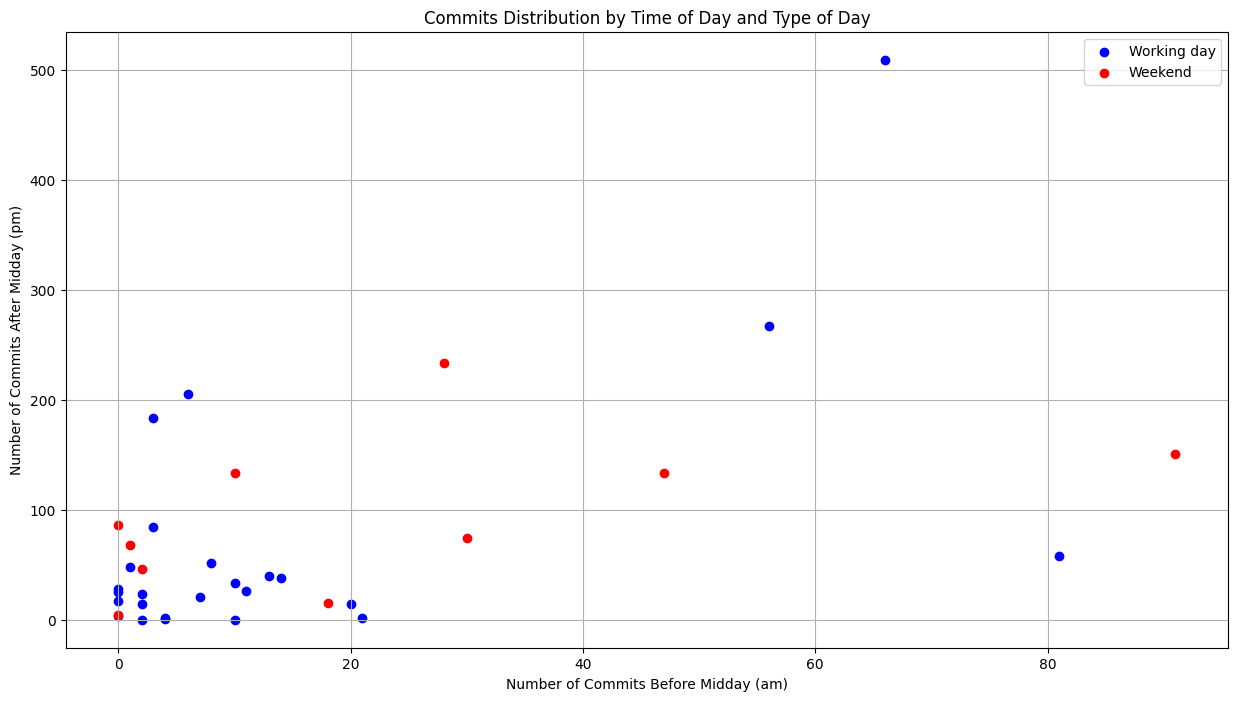

In [73]:
# Разделяем данные на рабочие и выходные
working_days = df[df['target'] == 'working_day']
weekends = df[df['target'] == 'weekend']

# Строим график
plt.figure(figsize=(15, 8))
plt.scatter(working_days['am'], working_days['pm'], color='blue', label='Working day')
plt.scatter(weekends['am'], weekends['pm'], color='red', label='Weekend')

# Подписи
plt.xlabel('Number of Commits Before Midday (am)')
plt.ylabel('Number of Commits After Midday (pm)')
plt.title('Commits Distribution by Time of Day and Type of Day')
plt.legend()
plt.grid(True)
plt.show()

### Answer the question:
- no, it is not easy

## 3. Logistic regression

- Train logistic regression on your data using `am` and `pm`, parameters are: `random state=21`, `fit_intercept=False`.


- Make predictions for every day of your dataset and add them to your dataframe with the column name `predict`.


- Save the dataframe into a file in the subfolder of the day `data` with the name `am_pm.csv`.


- Draw another plot like you did before, but the color should be taken from the `predict`.


- By looking at the graph do you think if it made good predictions? Put your answer in the markdown cell in the end of that section: "yes, it is good"; "no, it is not good".

In [74]:
# 1. Подготовка данных
X = df[['am', 'pm']]
y = (df['target'] == 'weekend').astype(int)  # 1 = weekend, 0 = working_day

In [75]:
# 2. Обучение логистической регрессии
model = LogisticRegression(random_state=21, fit_intercept=False)
model.fit(X, y)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,False
,intercept_scaling,1
,class_weight,None
,random_state,21
,solver,'lbfgs'
,max_iter,100
,multi_class,'deprecated'


In [76]:
# 3. Предсказания
pred_num = model.predict(X)
df['predict'] = np.where(pred_num == 1, 'weekend', 'working_day')
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35 entries, 0 to 34
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   date     35 non-null     object
 1   am       35 non-null     int64 
 2   pm       35 non-null     int64 
 3   target   35 non-null     object
 4   predict  35 non-null     object
dtypes: int64(2), object(3)
memory usage: 1.5+ KB


period,date,am,pm,target,predict
0,2020-04-17,21,2,working_day,weekend
1,2020-04-18,1,68,weekend,working_day
2,2020-04-19,18,15,weekend,working_day
3,2020-04-20,2,23,working_day,working_day
4,2020-04-21,0,25,working_day,working_day


In [77]:
# 4. Сохранение в файл
df.to_csv('../data/am_pm.csv', index=False)

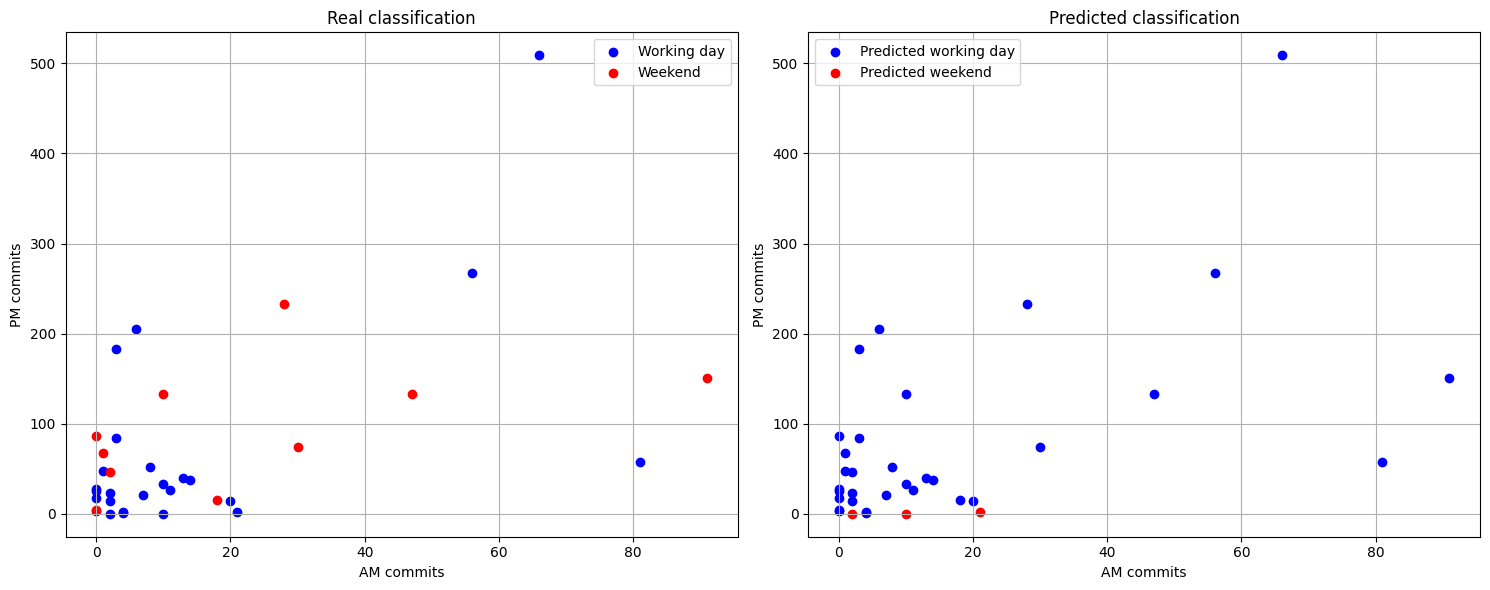

In [84]:
# 5. Два графика рядом
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# --- График 1: реальные данные ---
axes[0].scatter(df[df['target'] == 'working_day']['am'],
                df[df['target'] == 'working_day']['pm'],
                color='blue', label='Working day')
axes[0].scatter(df[df['target'] == 'weekend']['am'],
                df[df['target'] == 'weekend']['pm'],
                color='red', label='Weekend')
axes[0].set_title('Real classification')
axes[0].set_xlabel('AM commits')
axes[0].set_ylabel('PM commits')
axes[0].legend()
axes[0].grid(True)

# --- График 2: предсказания ---
axes[1].scatter(df[df['predict'] == 'working_day']['am'],
                df[df['predict'] == 'working_day']['pm'],
                color='blue', label='Predicted working day')
axes[1].scatter(df[df['predict'] == 'weekend']['am'],
                df[df['predict'] == 'weekend']['pm'],
                color='red', label='Predicted weekend')
axes[1].set_title('Predicted classification')
axes[1].set_xlabel('AM commits')
axes[1].set_ylabel('PM commits')
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.show()

### Answer the question:

-  No, it is not good

## 4. Evaluation

- Calculate `accuracy` for your predictions.


- Calculate `accuracy` for the naive case when each of your prediction is the value of your most popular class of the day.


- Comparing the accuracies do you think that the classifier made good predictions? Put your answer in the markdown cell in the end of the secion: "yes, it is good"; "no, it is not good".

In [79]:
# 1. Accuracy модели
accuracy = accuracy_score(df['target'], df['predict'])

In [80]:
# 2. Наивный классификатор — всегда предсказываем самый частый класс
most_common_class = df['target'].mode()[0]
naive_pred = [most_common_class] * len(df)
accuracy_naive = accuracy_score(df['target'], naive_pred)

In [81]:
print("Accuracy модели:", accuracy)
print("Accuracy наивного случая:", accuracy_naive)
print("Самый популярный класс:", most_common_class)

Accuracy модели: 0.6285714285714286
Accuracy наивного случая: 0.7142857142857143
Самый популярный класс: working_day


In [85]:
if accuracy > accuracy_naive:
    print('yes, it is good')
else:
    print('no, it is not good')

no, it is not good


### Answer the question:

-  No, it is not good